**Lab 4: FIR filters and envelopes**

The goal of this lab is to learn how to implement FIR filters in Python, and how we can use them to improve our synthesis.

In [33]:
import os
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from util import load_audio, plot_signals, plot_spectrogram, plot_mean_spectrogram

**1. Overview of Filtering**

For this lab, we will define an FIR filter as a discrete-time system that converts an input signal $x[n]$ into an output signal $y[n]$ by means of the weighted summation:

$$
y[n] = \sum_{k=0}^M b_kx[n-k]
$$

The function *np.convolve()* is a generic function with which to implement FIR filters. The following code implements a three-point averaging system:

In [34]:
fs = 1
x = [np.floor(x/10) for x in range(50)]
b = np.array([1.0/3, 1.0/3, 1.0/3])
y = np.convolve(b, x)

plot_signals([x, y], fs, name=['input x[n]', 'output y[n]'], mode='lines+markers')

1.1 Explain the filtering action of the 5-point averager by comparing the plot of the input $x[n]$ and the output $y[n]$. This filter might be called a “smoothing” filter. Note how the transitions from one level to another have been “smoothed.”

The 5-point averager, is used to smooth or average a signal. It operates by averaging the current sample and four previous samples from the input signal to create a smoother output. This filtering action reduces the impact of high-frequency noise and sharp transitions in the input. We can see this from the example above by noteching how the transitions last longer and have less of an angle of attack. It's an overall smoother graphic than the blue one.

*1.2* Define a function `averaging_filter(x, N)` which implements the N-points averaging filter using the `np.convolve` function.

In [35]:
import numpy as np

def averaging_filter(x, N):
    """
    Applies a N-point averaging filter to the input signal x

    Parameters
    ----------
    x : np.array
        The input signal in the form of a numpy array
    N : int
        The number of points used in N-point averaging filter

    Returns
    -------
    y : np.array
        The output of the filter
    """

    # Write your code here
    b = np.ones(N) / N
    y = np.convolve(b, x, mode=mode)
    return y


1.3 Run the example above using the `averaging_filter` instead. Change the number N to different values and explain what happen.

In [36]:
# Recreate the step-like example
fs = 1
x = np.array([np.floor(v/10) for v in range(50)])  # same as given example

# Try different N values
Ns = [3, 5, 11]
plot_signals([x, y, b], fs, name=['input x[n]', 'output y[n]', 'b'], mode='lines+markers')


1.4 How would you classify this filter, as a low-pass o high-pass filter?

It smooths the signal by averaging a range of samples, which effectively reduces the impact of high-frequency noise or rapid changes in the signal. This behavior makes it a low-pass filter, as it passes the lower-frequency components and attenuates the higher-frequency components, resulting in a smoother signal.







---

**2. Envelope detector**

Now we'll implement an envelope detector by concatenating two systems: a full-wave rectifier (absolute value) and the N-point averaging filter.

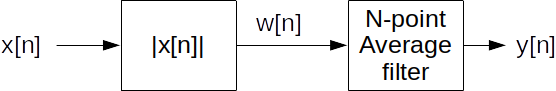

2.1 Define a function `envelope(x, N)` which applies an N-point averaging filter to the full-wave rectified signal and returns the output $y[n]$.

**Note 1**: to calculate the full-wave rectified signal check the `np.abs()` function.

**Note 2**: The output should have the same length as the input signal. Use 'same' mode (see [np.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) documentation).

In [37]:
import numpy as np

def envelope(x, N):
    """
    Extracts the envelope of x by full-wave rectification followed by an N-point moving average.
    Output length matches input (mode='same').
    """
    # full-wave rectification
    xr = np.abs(x)                                           # |x[n]| [attached_file:1]
    # N-point averaging filter (FIR with N equal taps)
    b = np.ones(int(N), dtype=float) / float(N)              # coefficients sum to 1 [attached_file:1]
    y = np.convolve(xr, b, mode='same')                      # keep same length [attached_file:1]
    return y, b


2.2 Load your reference signal and calculate its envelope using the function you designed. Plot the reference signal and envelope in the same figure.

In [38]:
!git clone https://github.com/paablomorillo/sis1_group103.git
filepath = "./sis1_group103/audiosys.wav"
ref, fs = load_audio(filepath)
T = 1 / 350
y, kernel = envelope(ref, N=5)
plot_signals([ref, y], fs, t_start = 0.1725, t_end = 0.1725 + 5*T, name=['input x[n]', 'output y[n]'])

fatal: destination path 'sis1_group103' already exists and is not an empty directory.


2.3 Change the number N to get a good result. What happens when you change the number N?

Increasing N makes the envelope smoother but slower to follow rapid amplitude changes, while decreasing N makes it track faster but with more ripple and noise leakage from the carrier into the envelope.

2.4 Explain with your own words why this system achieves extracting the envelope. It might be useful to plot together the signals $x[n]$, $w[n]$ and $y[n]$.

In [49]:
N = 50
w = np.abs(ref)
y_env, _ = envelope (ref, N)

t = np.arange(len(x))/fs
t0, t1 = 0.1725, 0.1725 + 5*(1/350)                    # same window as instructions [attached_file:1]


plot_signals([ref, w, y_env], fs, t_start=t0, t_end=t1, name=['input x[n]', 'output y[n]', 'kernel w[n]'])


By first flipping all negative samples to positive so fast oscillations no longer cancel, and then low‑pass averaging to suppress the carrier while keeping slow amplitude changes, the system leaves a smooth curve that tracks the signal’s amplitude over time, i.e., its envelope.

2.5 Now let's apply this envelope to the synthesized signal. Copy the code from Lab3 Ex. 2.1 and generate the synthesized signal. Then multiply the synthesized signal by the envelope. Note that both signal and envelope should have the same length. You can define a time vector of the same length of the envelope to create the signal:

In [40]:
# Write your code here
weights = [0.117, 1, 0.118, 0.126, 0.071, 0.012, 0.014, 0.01, 0.027, 0.016, 0.009, 0.0088, 0.006, 0.003, 0.0039, 0.0035, 0.0036, 0.0047, 0.0027, 0.0053, 0.0068, 0.011, 0.018, 0.02, 0.015, 0.02, 0.003]
def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, len(Ak) + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y

f0 = 350
T = 1 / f0

duration = len(ref) / fs
t = np.linspace(0, duration, len(ref))
synthesized_signal = synthesize(f0, -2.7, weights, t)

synth_signal = synthesized_signal / np.max(np.abs(synthesized_signal))
ref = ref / np.max(np.abs(ref))
y = y / np.max(np.abs(y))
t_start = 1.10  
t_end = t_start + 5 * T
mult_signal = synth_signal * y
plot_signals([ref, synth_signal, mult_signal], fs, t_start=t_start, t_end=t_end, name=['ref', 'synthesized signal', 'multiplied signal'])

2.6. Compare the spectrograms of the reference signal and the synthesized signal. What are the main differences?

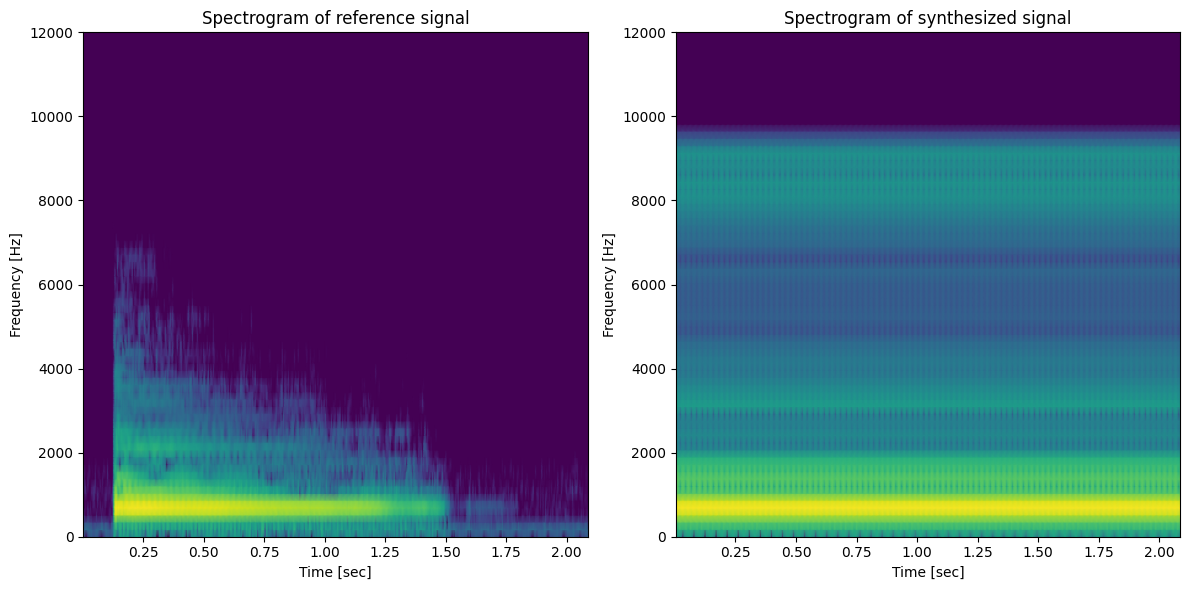

In [55]:
# Write your code here
import scipy.signal as sig
ff, tt, S_envelope = sig.spectrogram(synth_signal, fs=fs, window='hann')
ff, tt, S_ref = sig.spectrogram(ref, fs=fs, window='hann')

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_spectrogram(ff, tt, S_ref)
plt.ylim(0, 12000)
plt.title('Spectrogram of reference signal')

plt.subplot(1,2,2)
plot_spectrogram(ff, tt, S_envelope)
plt.ylim(0, 12000)
plt.title('Spectrogram of synthesized signal')

plt.tight_layout()
plt.show()



2.7 Listen to the synthesized signal and compare it to the reference.



In [ ]:
# Write your code here
import IPython.display as ipd
ipd.display(ipd.Audio(ref, rate=fs))
ipd.display(ipd.Audio(synth_signal, rate=fs))
ipd.display(ipd.Audio(mult_signal, rate=fs))

The multiplied signal sounds closer to the reference than the raw synthesized tone because applying the envelope shapes the carrier’s amplitude to follow the reference’s slow variations, reducing the mismatch in loudness contours across time.